In [18]:
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

#get automap setup
Base = automap_base()

In [22]:
#make an inspector
inspector = inspect(engine)
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)
df = pd.read_sql_table('measurement',engine)

# Exploratory Precipitation Analysis

In [67]:
activest = session.query(Measurement.station,func.count(Measurement.station).label('qty'))\
.filter(func.strftime('%Y,%m,%d',Measurement.date) >= func.strftime('%Y,%m,%d',year_ago))\
.group_by(Measurement.station).order_by(desc('qty')).first()
#
activest = activest[0]

('USC00519397', 361)

In [52]:
# from sqlalchemy import func, desc
# session.query(tablename.category,func.count(tablename.id).label('qty')).\
#group_by(tablename.category).order_by(desc('qty'))

SyntaxError: unexpected EOF while parsing (<ipython-input-52-0ab849ae49d0>, line 8)

In [33]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(desc('date')).first()
latest_date = latest_date[0]

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set
#put the date in a type we can work with
x = latest_date.split('-',1) 
year = int(x[0])
last_year = str(year-1)
x[0] = last_year
year_ago = '-'.join(x)

In [37]:
# Perform a query to retrieve the data and precipitation scores
#set the scope of what we want from the table
sel = [Measurement.date,\
       Measurement.prcp]

#make the query
latest_year = session.query(*sel).\
    filter(func.strftime('%Y,%m,%d',Measurement.date) >= \
           func.strftime('%Y,%m,%d',year_ago)).\
                                order_by(Measurement.date).all()

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [36]:
#pull the list of columns to establish indicies
col_list = ['date','precipitation']
                            
# Save the query results as a Pandas DataFrame and set the index to the date column
latest_year_df = pd.DataFrame(latest_year,columns=col_list)
latest_year_df.set_index('date',inplace=True)
latest_year_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


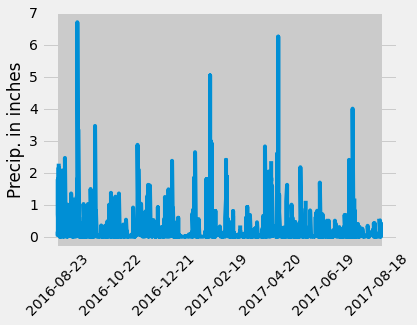

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
plt.plot(latest_year_df.index.values,latest_year_df['precipitation'])
plt.tight_layout()
#formatting solution from stackoverflow
every_nth = 60
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.ylabel('Precip. in inches')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
latest_year_df[['precipitation']].describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
df.station.value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [15]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Measurement.station).distinct().count()

print(f'There are {stations} stations')

There are 9 stations


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,func.\
                                count(Measurement.station)).\
                                group_by(Measurement.station).statement

#put into dataframe for sorting
station_df = pd.read_sql_query(station_activity,engine)
station_df.sort_values(by='count_1',ascending=False,inplace=True)

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
activest = str(station_df['station'].values[0])

#set parameters
sel2 = [Measurement.date,\
       Measurement.tobs]

#make the query
activest_st = session.query(*sel2).\
    filter(Measurement.station == activest).\
    filter(func.strftime('%Y,%m,%d',Measurement.date) >= \
           func.strftime('%Y,%m,%d',year_ago)).\
                                order_by(Measurement.date).all()
#create DataFrame
col_list=['date','temperature']
activest_df = pd.DataFrame(activest_st,columns=col_list)

#get summary stats
temps = activest_df[['date','temperature']]
temps.temperature.describe()

count    352.000000
mean      73.107955
std        4.733315
min       59.000000
25%       70.000000
50%       74.000000
75%       77.000000
max       83.000000
Name: temperature, dtype: float64

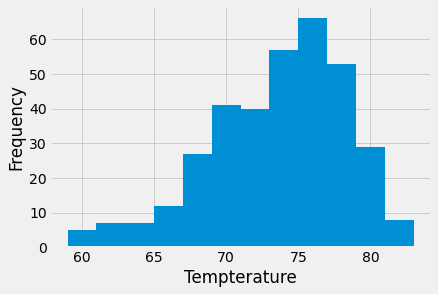

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(activest_df.temperature,bins=12)
plt.tight_layout()
plt.xlabel('Tempterature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [19]:
# Close Session

session.close()